In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
from scipy.optimize import minimize
import yfinance as yf
import seaborn as sns
%load_ext autoreload
%autoreload 2
import Risk_kit as rk

In [3]:
#getting data from yfinance
tickers = ['RVNL.NS', 'HDFCBANK.NS', 'INFY.NS', 'NHPC.NS', 'ITC.NS', 'SUNPHARMA.NS', 'BHARTIARTL.NS', 'TATAMOTORS.NS', 'HINDUNILVR.NS', 'GODREJPROP.NS']
data = yf.download(tickers, start='2021-7-9', end='2024-7-9') #fetching monthly data for 3 years
price_data=data['Close'] #taking the closing price to determine returns
returns = price_data[tickers].pct_change().dropna()
returns.dropna(inplace=True)
rets = pd.DataFrame(returns)

[*********************100%***********************]  10 of 10 completed


In [4]:
cov_matrix = rets.cov() #to get covariance between the assets
cov_matrix.head()

,RVNL.NS,HDFCBANK.NS,INFY.NS,NHPC.NS,ITC.NS,SUNPHARMA.NS,BHARTIARTL.NS,TATAMOTORS.NS,HINDUNILVR.NS,GODREJPROP.NS
RVNL.NS,0.001165,0.000036,0.000053,0.000280,0.000066,0.000023,0.000090,0.000144,0.000023,0.000174
HDFCBANK.NS,0.000036,0.000191,0.000064,0.000038,0.000039,0.000033,0.000056,0.000085,0.000038,0.000106
INFY.NS,0.000053,0.000064,0.000237,0.000043,0.000042,0.000045,0.000058,0.000080,0.000045,0.000101
NHPC.NS,0.000280,0.000038,0.000043,0.000563,0.000049,0.000041,0.000041,0.000112,0.000021,0.000160
ITC.NS,0.000066,0.000039,0.000042,0.000049,0.000177,0.000044,0.000044,0.000094,0.000047,0.000087


In [7]:
#calculating annualized returns using the function from the risk module
ann_rets = pd.Series(rk.annualized_return(rets))
ann_rets

0    1.662642
1    0.029471
2    0.021141
3    0.601288
4    0.309591
5    0.334925
6    0.408459
7    0.499157
8    0.018567
9    0.316463
dtype: float64

<Axes: >

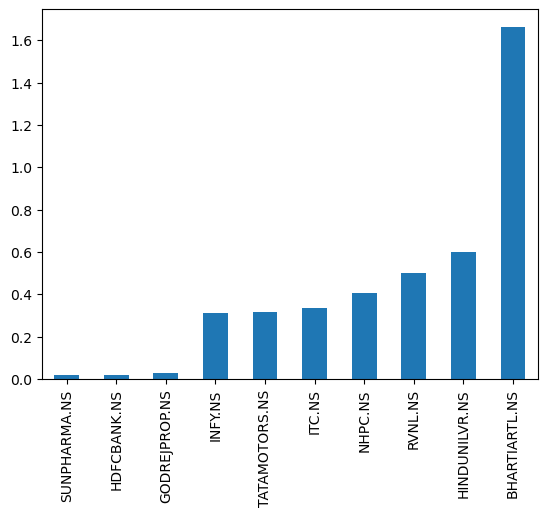

In [8]:
#plotting the annual returns of the assets
column_names = price_data.columns
ann_rets.index=column_names
ann_rets.sort_values().plot.bar()

In [9]:
#calculating weights to optimize for the maximum sharpe ratio using msr function from the risk module
weights=rk.msr(0.03,ann_rets, cov_matrix)
#return of the optimized portfolio
r=rk.portfolio_return(weights,ann_rets)
#volatility of the optimized portfolio
vol=rk.portfolio_vol(weights,cov_matrix)

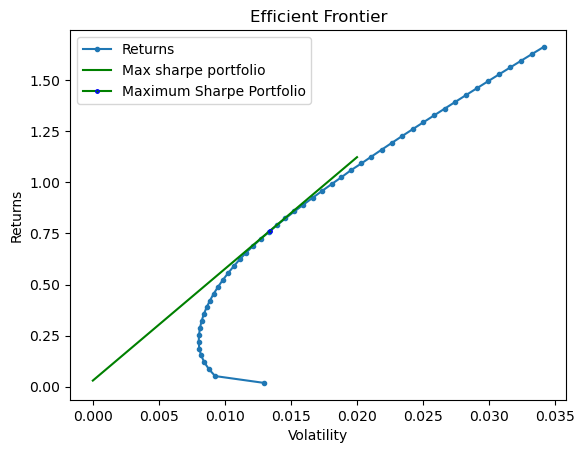

In [10]:
#PLotting the efficient frontier, and locating the portfolio having maximum Sharpe ratio
rk.plot_ef(50, ann_rets, cov_matrix)
#Plotting the line for returns of the risk free asset (risk free returns = 3%)
x=[0,0.020]
y=[0.03,0.020*(r-0.03)/vol+0.03]
plt.title("Efficient Frontier")
plt.plot(x,y,label='Max sharpe portfolio',color="green")
plt.plot(vol,r, color='green', marker='.',markersize=5, markeredgecolor= 'blue',label="Maximum Sharpe Portfolio")
plt.ylabel("Returns")
plt.legend()
plt.show()

In [11]:
sharpe = (r-0.03)/vol
print(f"The return of the portfolio is {r*100}%")
print(f"The volatility of the portfolio is {vol*100}%")
print(f"The Sharpe Ratio of the portfolio is {sharpe}")

The return of the portfolio is 76.24907507682173%
The volatility of the portfolio is 1.340111215160773%
The Sharpe Ratio of the portfolio is 54.65895236764661


In [12]:
#CPPI

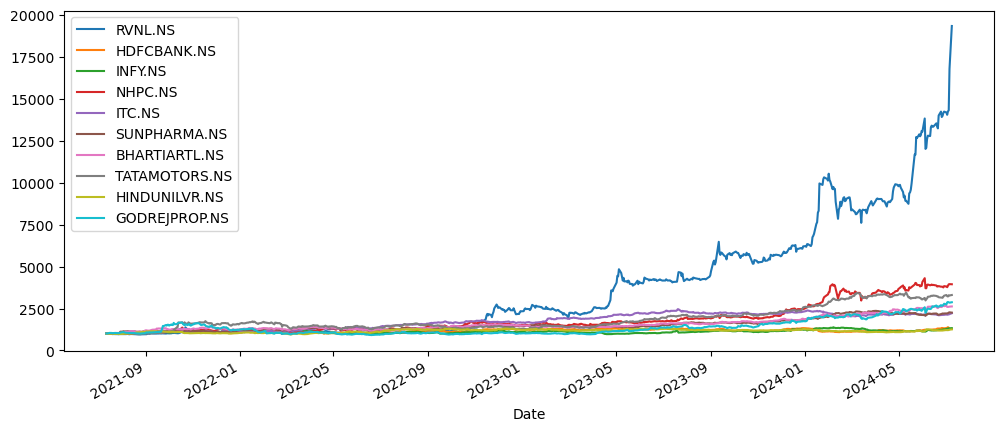

In [13]:
#Taking the same 10 assets as risky assets and using them as risky assets in CPPI
df = rk.run_cppi( rets,safe_r=None, m=3, start=1000, floor=0.8, riskfree_rate=0.03, drawdown=None)
# plotting the wealth index after running cppi
ax = df["Wealth"].plot(figsize=(12,5))   

<Axes: xlabel='Date'>

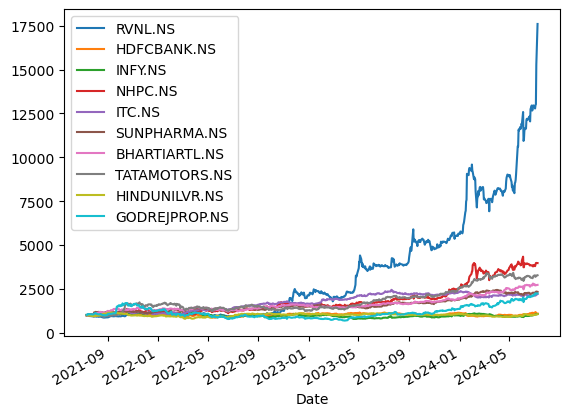

In [14]:
#plotting returns if all the initial amount was placed in the risky asset
df["Risky Wealth"].plot()

In [15]:
#calculating the return series for the portfolio where cppi was used
cppi_rets = df["Wealth"].pct_change().dropna()

In [16]:
#performance of the portfolio
rk.summary_stats(cppi_rets)

,index,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Sharpe Ratio
0,RVNL.NS,1.751682,0.114430,1.648962,11.098699,0.027193,15.045718
1,HDFCBANK.NS,0.090364,0.041931,-0.377490,10.984219,0.018796,1.439605
2,INFY.NS,0.104075,0.044648,-0.219244,7.876656,0.020233,1.659076
3,NHPC.NS,0.599642,0.081033,-0.134273,10.612619,0.033604,7.029754
4,ITC.NS,0.312804,0.044091,-0.151073,5.619126,0.019628,6.414145
5,SUNPHARMA.NS,0.319811,0.043973,0.654691,5.859155,0.016489,6.590692
6,BHARTIARTL.NS,0.393746,0.048824,0.064156,4.623817,0.021031,7.450092
7,TATAMOTORS.NS,0.503286,0.072701,1.290722,17.102344,0.018342,6.510034
8,HINDUNILVR.NS,0.081457,0.038907,0.013777,7.291885,0.017072,1.322569
9,GODREJPROP.NS,0.427626,0.073771,0.226323,9.158311,0.029331,5.389976
